<a href="https://colab.research.google.com/github/NiliSoleil/MLP-Loss-Functions-and-Optimizers/blob/main/MLP_Loss_Functions_Optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports 📢**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 10.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
from sklearn.metrics import r2_score

# **Dataset 🗂️**

## Read Dataset

In [ ]:
# !cp your_address /content/

!unzip /content/data.zip

Archive:  /content/data.zip
  inflating: housing.csv             


In [ ]:
housing_dataset = pd.read_csv("/content/housing.csv")
#print(housing_dataset.isnull())

# Replace the missing values for total_bedrooms column with mean
housing_dataset['total_bedrooms'] = housing_dataset['total_bedrooms'].fillna(housing_dataset['total_bedrooms'].mean())
## or you can use:
# housing_dataset.dropna(subset=['total_bedrooms'], inplace=True)  # Drop 207 NaNs for simplicity
X = housing_dataset.drop(['ocean_proximity', 'median_house_value'], axis=1).values
y = housing_dataset['median_house_value'].values

print(X.shape)

(20640, 8)


## Split

In [ ]:
train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

# print(f"X_train shape: {X_train.shape}")
# print(f"X_valid shape: {X_valid.shape}")
# print(f"X_test shape: {X_test.shape}")

## Preprocess

In [ ]:
# Convert to tensor
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(y_valid)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Standardization
mu_x = torch.mean(X_train, dim=0)
std_x = torch.std(X_train, dim=0)

mu_y = torch.mean(y_train, dim=0)
std_y = torch.std(y_train, dim=0)

X_train = (X_train - mu_x) / std_x
X_valid = (X_valid - mu_x) / std_x
X_test = (X_test - mu_x) / std_x

y_train = (y_train - mu_y) / std_y
y_valid = (y_valid - mu_y) / std_y
y_test = (y_test - mu_y) / std_y

## Dataloader

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=256)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=256)

# **Model 🧠**

In [ ]:
in_features = 8
out_features = 1
h1 = 64
h2 = 32

model = nn.Sequential(nn.Linear(in_features, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, out_features))

model

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

# **Device ⚙️**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print(torch.cuda.get_device_name())

Tesla T4


# **Loss ⚖️**

## MSELoss

In [ ]:
loss_fn = nn.MSELoss()

## N1Loss

In [ ]:
loss_fn = nn.L1Loss()

## HuberLoss

In [ ]:
loss_fn = nn.HuberLoss()

## AdaptiveLoss

In [ ]:
def loss_fn(outputs, targets, c=1., alpha=1.):

  if alpha == 2:
    loss = 1 / 2 * torch.pow((outputs - targets) / c, 2)
    return torch.mean(loss)

  elif alpha == 0:
    loss = torch.log(1 / 2 * torch.pow((outputs - targets) / c, 2) + 1)
    return torch.mean(loss)

  elif alpha == -torch.inf:
    loss = 1 - torch.exp(-1 / 2 * torch.pow((outputs - targets) / c, 2))
    return torch.mean(loss)

  else:
    loss =  (abs(alpha - 2) / alpha) * (torch.pow(torch.pow((outputs - targets) / c, 2)/abs(alpha - 2) + 1, alpha/2) - 1)
    return torch.mean(loss)

# **Optimizer📻**

## Adam

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## SGD

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## SGD_M

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## SGD_Nest

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

## rmsprop

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)

# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Train Loop👨🏼‍🏫**

In [ ]:
loss_train_hist = []
loss_valid_hist = []

num_epochs = 300

for epoch in range(num_epochs):
  # Train
  model.train()
  loss_train = AverageMeter()
  for i, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    loss = loss_fn(outputs.squeeze(), targets)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_train.update(loss.item())

  loss_train_hist.append(loss_train.avg)

  # Validation
  model.eval()
  loss_valid = AverageMeter()
  with torch.no_grad():
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.squeeze(), targets)

      loss_valid.update(loss.item())

    loss_valid_hist.append(loss_valid.avg)

  if epoch % 10 == 0:
    print(f'Epoch {epoch}')
    print(f'Train: Loss = {loss_train.avg:.4}')
    print(f'Valid: Loss = {loss_valid.avg:.4}')
    print()

Epoch 0
Train: Loss = 0.1443
Valid: Loss = 0.131

Epoch 10
Train: Loss = 0.0989
Valid: Loss = 0.1095

Epoch 20
Train: Loss = 0.0908
Valid: Loss = 0.1026

Epoch 30
Train: Loss = 0.08651
Valid: Loss = 0.0961

Epoch 40
Train: Loss = 0.084
Valid: Loss = 0.09533

Epoch 50
Train: Loss = 0.0821
Valid: Loss = 0.09707

Epoch 60
Train: Loss = 0.08112
Valid: Loss = 0.08923

Epoch 70
Train: Loss = 0.08029
Valid: Loss = 0.08954

Epoch 80
Train: Loss = 0.07903
Valid: Loss = 0.08947

Epoch 90
Train: Loss = 0.07797
Valid: Loss = 0.09016

Epoch 100
Train: Loss = 0.077
Valid: Loss = 0.09009

Epoch 110
Train: Loss = 0.07649
Valid: Loss = 0.0881

Epoch 120
Train: Loss = 0.07592
Valid: Loss = 0.08591

Epoch 130
Train: Loss = 0.07516
Valid: Loss = 0.08612

Epoch 140
Train: Loss = 0.07471
Valid: Loss = 0.0872

Epoch 150
Train: Loss = 0.07422
Valid: Loss = 0.08923

Epoch 160
Train: Loss = 0.07396
Valid: Loss = 0.08881

Epoch 170
Train: Loss = 0.07286
Valid: Loss = 0.08591

Epoch 180
Train: Loss = 0.07258
Vali

In [ ]:
!mkdir /content/comparision

**Initilizing and then Training model for each Optimizer.**

In [ ]:
optim = 'adam'

torch.save(torch.tensor(loss_train_hist), f'/content/comparision/{optim}-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'/content/comparision/{optim}-loss-valid.pt')

In [ ]:
optim = 'sgd'

torch.save(torch.tensor(loss_train_hist), f'/content/comparision/{optim}-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'/content/comparision/{optim}-loss-valid.pt')

In [ ]:
optim = 'sgd-m'

torch.save(torch.tensor(loss_train_hist), f'/content/comparision/{optim}-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'/content/comparision/{optim}-loss-valid.pt')

In [ ]:
optim = 'sgd-nest'

torch.save(torch.tensor(loss_train_hist), f'/content/comparision/{optim}-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'/content/comparision/{optim}-loss-valid.pt')

In [ ]:
optim = 'rms'

torch.save(torch.tensor(loss_train_hist), f'/content/comparision/{optim}-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'/content/comparision/{optim}-loss-valid.pt')

# **Comparison🔎**

## Plot

In [ ]:
def plot_lcs(x:str, y:str):
  plt.figure(figsize=(8, 6))
  #
  for optim in ['sgd', 'sgd-m', 'sgd-nest', 'rms', 'adam']:
    z = torch.load(f'/content/comparision/{optim}-{x}-{y}.pt')
    #
    plt.plot(range(num_epochs), z, label=optim)
    plt.xlabel('epoch')
    plt.ylabel(f'{x} {y}')
    plt.grid(True)
    plt.legend()

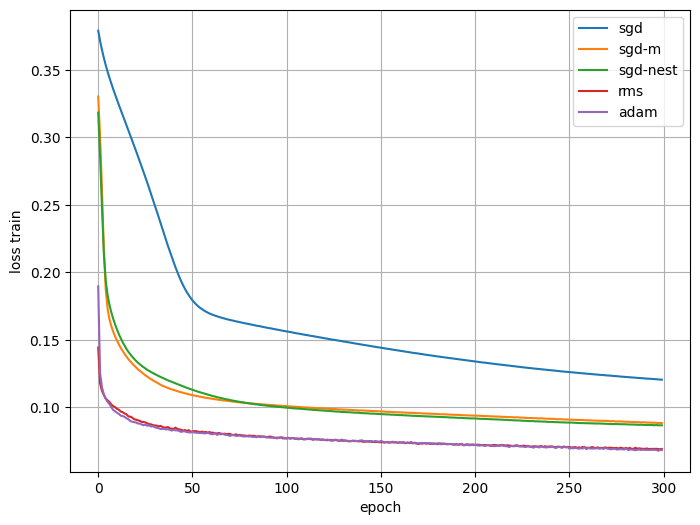

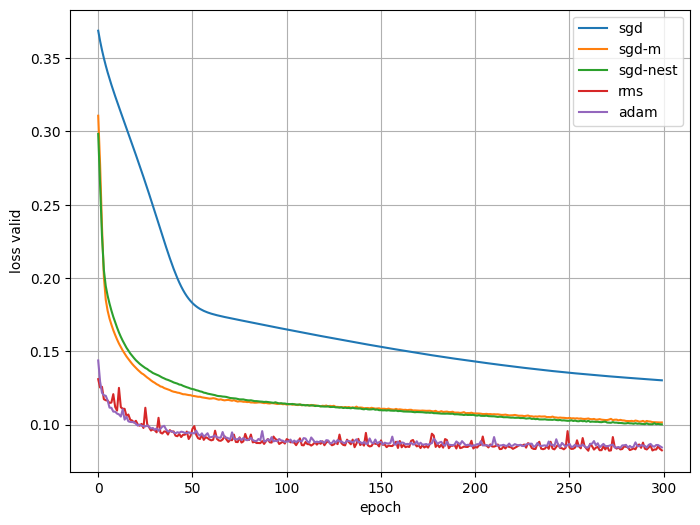

In [ ]:
plot_lcs('loss', 'train')
plot_lcs('loss', 'valid')

## R2 score

**R2 Scores for each Loss Function**

In [ ]:
yp_total = []
yt_total = []

with torch.no_grad():
  for inputs, targets in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    yp = model(inputs)
    yp_total.append(yp.squeeze().cpu())
    yt_total.append(targets.cpu())


yp_total = torch.cat(yp_total)
yt_total = torch.cat(yt_total)

r2_score(yt_total, yp_total)

Loss     | MSELoss  | N1Loss  | HuberLoss | AdaptiveLoss
---------|----------|---------|-----------|-------------  
R2 score | 0.8072   | 0.8031  | 0.7958    | 0.8061